# Import Library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from os import getcwd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cwd = getcwd() + "/drive/Shareddrives/CAPSTONE_ML/"
print(cwd)

/content/drive/Shareddrives/CAPSTONE_ML/


In [3]:
df_all = pd.read_excel(cwd + "df_all_new.xlsx")
df_all.head()

,Page_URL,Shop_name,Rating,Reviews,Kategori,Address,Phone_Number,Opening_Hours,Range_Harga,Latitude,Longitude,Eco_Friendly,Categorize_Weather
0,https://www.google.com/maps/place/Wedang+Uwuh+...,Wedang Uwuh Solo - Pak Aden,4.6,5,Wedang Uwuh,"Mutihan rt 04 rw 1, Surakarta, Sondakan, Kec. ...",082324006000,"{'Senin': ['08.00–20.00'], 'Selasa': ['08.00–2...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
1,https://www.google.com/maps/place/Rajanya+JAHE...,Rajanya JAHE REMPAH wedhang uwuh Sumber,4.6,32,Wedang Uwuh,"Jl. Letjen Suprapto No.76c, Sumber, Kec. Banja...",085641727445,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
2,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh jelantik solo,5.0,1,Wedang Uwuh,"Jl. Sungai Musi No.1, Sangkrah, Kec. Ps. Kliwo...",081229070267,"{'Senin': ['Buka 24 jam'], 'Selasa': ['Buka 24...",Rp 1–25 rb,-7.576765,110.768229,0,Dingin
3,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh mbok tuo,4.9,14,Wedang Uwuh,"Jl. Kutai Tim. 5B, RT.05/RW.08, Sumber, Kec. B...",081578614885,"{'Senin': ['07.00–19.00'], 'Selasa': ['07.00–1...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin
4,https://www.google.com/maps/place/wedang+uwuh+...,wedang uwuh sya,4.7,3,Wedang Uwuh,"Jl. Reksoniten No.20, Gajahan, Kec. Ps. Kliwon...",089608149211,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin


Fungsi untuk menghitung jarak menggunakan formula haversine

In [4]:
def calculate_haversine(lat1, lon1, lat2, lon2):
    earth_radius = 6371  # Radius bumi dalam kilometer
    delta_lat = np.radians(lat2 - lat1)
    delta_lon = np.radians(lon2 - lon1)
    a = np.sin(delta_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return earth_radius * c

Menghitung jarak tiap lokasi berdasarkan input latitude dan longitude pengguna

In [20]:
# Lokasi pengguna
current_lat = -7.5589608
current_lon = 110.856106

# Perhitungan jarak untuk setiap lokasi dalam dataset
df_all['computed_distance'] = df_all.apply(
    lambda row: calculate_haversine(current_lat, current_lon, row['Latitude'], row['Longitude']), axis=1
)


KeyError: 'compute_distance'

In [24]:
sorting_distance = df_all[["Page_URL","Shop_name", "Latitude", "Longitude", "computed_distance", "predicted_distance"]].sort_values(by='computed_distance', ascending=False).head(20)
print(sorting_distance)

                                              Page_URL  \
165  https://www.google.com/maps/place/Soto+mi+khas...   
107  https://www.google.com/maps/place/Tahok+%22Pak...   
108  https://www.google.com/maps/place/Tahok+kemban...   
109  https://www.google.com/maps/place/Tahok+%22Pak...   
110  https://www.google.com/maps/place/Tahok+Kemban...   
111  https://www.google.com/maps/place/Tahok+BalaDE...   
106  https://www.google.com/maps/place/Tahok+%22Pak...   
354  https://www.google.com/maps/place/Nasi+Liwet+M...   
490  https://www.google.com/maps/place/Sate+Kambing...   
260  https://www.google.com/maps/place/Selat+Solo+S...   
248  https://www.google.com/maps/place/Warung+Selat...   
285  https://www.google.com/maps/place/Selat+Solo+N...   
306  https://www.google.com/maps/place/Selat+solo+o...   
265  https://www.google.com/maps/place/SELAT+SOLO+c...   
267  https://www.google.com/maps/place/SELAT+SOLO+d...   
247  https://www.google.com/maps/place/Selat+Pak+To...   
246  https://w

Persiapan data untuk model


In [6]:
C = df_all['Rating'].mean()
M = df_all['Reviews'].quantile(0.5)

# Hitung Weighted Rating
df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# Menyiapkan data fitur dan target
features = df_all[['computed_distance', 'weighted_rating']]
target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# Normalisasi data fitur
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)


dataset = tf.data.Dataset.from_tensor_slices(dict(X_train), y_train)
# dataset = dataset.shuffle().batch(100)

ValueError: Unbatching a tensor is only supported for rank >= 1

In [7]:
# Hitung Weighted Rating
C = df_all['Rating'].mean()
M = df_all['Reviews'].quantile(0.5)
df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# Menyiapkan data fitur dan target
features = df_all[['computed_distance', 'weighted_rating']]
target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# Normalisasi data fitur
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target.to_numpy(), test_size=0.2, random_state=42)

# Pastikan bentuk data benar
print("X_train shape:", X_train.shape)  # (jumlah_data, jumlah_fitur)
print("y_train shape:", y_train.shape)  # (jumlah_data,)

# Buat dataset TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Opsional: Tambahkan shuffling dan batching
dataset = dataset.shuffle(buffer_size=100).batch(32)

X_train shape: (485, 2)
y_train shape: (485,)


Membuat arsitektur model. Menggunakan adam optimizer dan loss Mean Squared Error dan menambahkan metrics mae (pengennya accuracy)

In [8]:
# Membuat arsitektur model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Kompilasi model
model1.compile(optimizer='adam', loss="mse", metrics=['mae'])  # Loss: Mean Squared Error, Metrics: Mean Absolute Error

Memulai proses training dan menyimpannya kedalam variable history

In [9]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2008.0740 - mae: 17.5156 - val_loss: 2124.1423 - val_mae: 17.6525
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2563.0896 - mae: 17.4847 - val_loss: 1937.2509 - val_mae: 13.1217
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1498.2399 - mae: 11.9851 - val_loss: 1759.5464 - val_mae: 13.6703
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1736.5499 - mae: 15.4536 - val_loss: 1728.9753 - val_mae: 12.6742
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 989.2230 - mae: 12.0866 - val_loss: 1703.8109 - val_mae: 12.0523
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 937.6786 - mae: 11.2483 - val_loss: 1651.4637 - val_mae: 12.5858
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1255.5067 - mae: 13.4979 - val_loss: 1591.1443 - val_mae: 12.5286
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1031.7079 - mae: 11.9826 - val_loss: 1519.8816 - val_mae: 11.836

Menguji performa model setelah dilakukan training

In [10]:
test_loss, test_mae = model1.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error pada data uji: {test_mae}")

Mean Absolute Error pada data uji: 0.06711040437221527


In [19]:
# Membuat prediksi pada data baru
df_all['predicted_distance'] = model1.predict(features_normalized)

# Mendapatkan rekomendasi berdasarkan jarak terprediksi
top_recommendations = df_all.sort_values(by='predicted_distance', ascending=False).head(20)

# Menampilkan rekomendasi
print("Rekomendasi teratas berdasarkan prediksi jarak:")
print(top_recommendations[['Shop_name', 'Latitude', 'Longitude', 'Rating', 'Reviews', 'Categorize_Weather', 'computed_distance','predicted_distance']])


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Rekomendasi teratas berdasarkan prediksi jarak:
                                 Shop_name  Latitude   Longitude  Rating  \
165          Soto mi khas bogor "mbak Yul" -7.055318  106.177642     5.0   
106      Tahok "Pak Wagiman" KretegGantung -7.569240  106.995623     4.7   
108                     Tahok kembang tahu -7.569240  106.995623     4.7   
110               Tahok Kembang Tahu Menco -7.569240  106.995623     5.0   
107           Tahok "Pak Tris" Pasar Gedhe -7.569240  106.995623     5.0   
109     Tahok "Pak Tris" CFD Slamet Riyadi -7.569240  106.995623     5.0   
111                         Tahok BalaDEWA -7.569240  106.995623     0.0   
354                  Nasi Liwet Mbak Menik -7.562688  108.518325     4.7   
490                 Sate Kambing Pak Wawan -7.564592  110.076137     4.5   
260           Selat Solo Sarihayati Mb Nia -7.693490  110.312359     4.2   
248        Warung Selat & Catering Anugrah -7.536113  110.318702     4.2   


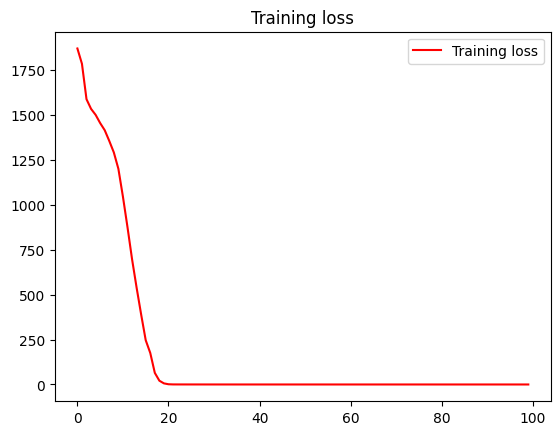

In [16]:
# Plot the training loss for each epoch
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

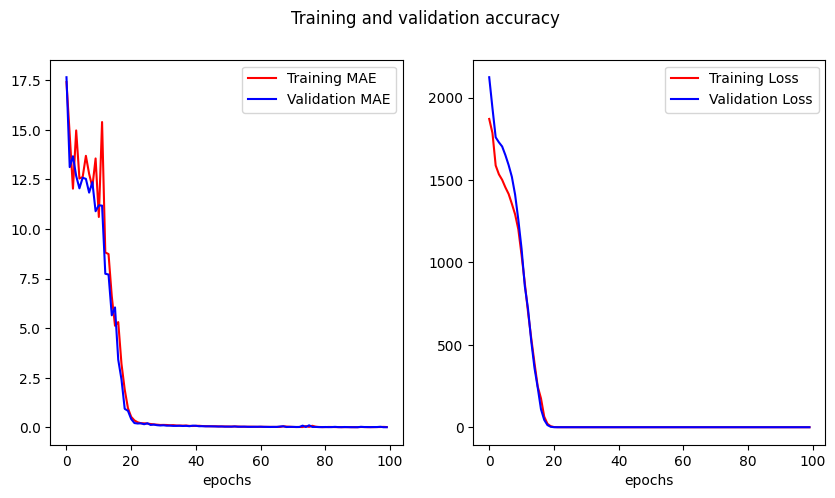

In [17]:
# Get training and validation accuracies
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(mae))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(mae, val_mae), (loss, val_loss)], ["MAE", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()